## Лабораторная работа по курсу "Искусственный интеллект"
## Многослойный персептрон

| Студент |  Ефимов  |
|---------|----------|
| Группа  | М8О-307Б |

Используемый датасет представляет собой множество монотонных $28x28$ картинок одежды, заранее
классифицированных по виду, доступен [по ссылке](https://github.com/zalandoresearch/fashion-mnist).

In [1]:
data_folder = "data/fashion-mnist/"
# !curl -o {data_folder + "mnist.pkl.gz"} https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz
# !gzip -d {data_folder + "mnist.pkl.gz"}

Перед загрузкой данных следует заранее добавить все используемые библиотеки:

In [2]:
import torch
import torch.nn.functional as F
import pickle
import pandas as pd
import matplotlib.pyplot as plt 

from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics         import confusion_matrix, ConfusionMatrixDisplay

Собственно сама загрузка данных:

In [3]:
train = pd.read_csv(data_folder + "/fashion-mnist_train.csv").values
test = pd.read_csv(data_folder + "/fashion-mnist_test.csv").values

y_train, X_train = train[:, 0], train[:, 1:]
y_test, X_test = test[:, 0], test[:, 1:]
print(y_train)
print(X_train.shape)

[2 9 6 ... 8 8 7]
(60000, 784)


Данные можно загрузить в более доступный для нейронных сетей формат - тензоры.

In [4]:
X_train = torch.tensor(X_train, dtype=torch.float32).div_(255)
X_test = torch.tensor(X_test, dtype=torch.float32).div_(255)
y_train = torch.tensor(y_train, dtype=torch.int64)
y_test = torch.tensor(y_test, dtype=torch.int64)

Особенности нормализуются сразу (делением на $255$).

Полученные данные легче загрузить во встроенный организатор данных:

In [5]:
train_set    = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_set, batch_size=20)

test_set    = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_set, batch_size=20)

`Pytorch` позволяет собрать из готовых классов, содержащих функции для работы над тензорами, нейронную сеть для своих целей. Следующий класс содержит два линейных слоя, разделенных функцией активации __Tanh__, и слой __Softmax__.

In [6]:
class SimpleNet(nn.Module):
    def __init__(self, hidden_layer_count=128):
        super().__init__()
        self.l1 = nn.Linear(784, hidden_layer_count)
        self.l2 = nn.Tanh()
        self.l3 = nn.Linear(hidden_layer_count, 10)
        self.l4 = nn.Softmax(dim=1)

    def forward(self, data):
        data = self.l1(data)
        data = self.l2(data)
        data = self.l3(data)
        data = self.l4(data)
        return data

У этого класса нет метода тренировки, а функции оптимизатора и счетчик потерь вынесены в отдельные классы
отдельные классы, поэтому необходимо задать дополнительную функцию, выполняющую тренировку (в данном случае
оптимизатор - _stochastic gradient descent_):

In [7]:
def train(net, dataloader, lr=0.03, loss_f=None):
    net.train()
    if loss_f is None:
        loss_f = nn.CrossEntropyLoss()
    
    optimizer = torch.optim.SGD(net.parameters(), lr)
    for (x, y) in dataloader:
        optimizer.zero_grad()
        data = net(x)
        loss = loss_f(data, y)
        loss.backward()
        optimizer.step()

@torch.no_grad()
def get_accuracy(net, data, labels):
    net.eval()
    y_predict = net.forward(data)
    y_predict = torch.argmax(y_predict, dim=1)
    comp = (y_predict == labels)
    return comp.sum() / comp.shape[0]
        
def train_graph(net, epoch=10):
    train_accuracies = []
    test_accuracies  = []
    
    for _ in range(epoch + 1):
        train_accuracies.append(get_accuracy(net, X_train, y_train))
        test_accuracies.append(get_accuracy(net, X_test, y_test))
        
        train(net, train_loader)

    plt.plot(range(epoch + 1), train_accuracies, 'g-')
    plt.plot(range(epoch + 1), test_accuracies,  'k--')
    plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower center')
    plt.show()
    

Декоратор `no_grad` нужен для избежания посторения графа вычислений в обернутой функции.

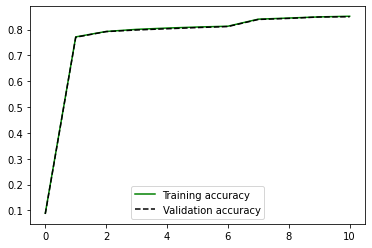

CPU times: user 1min 34s, sys: 527 ms, total: 1min 34s
Wall time: 24.1 s


tensor(0.8530)

In [8]:
net = SimpleNet(256)

%time train_graph(net, 10)
get_accuracy(net, X_test, y_test)

Точность примерно $81\%$, хуже среднего для такой модели. 

Можно рассмотреть подробнее ошибки классификации через матрицы:

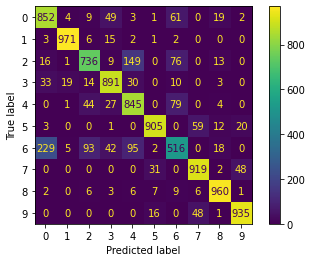

In [9]:
net.eval()

y_predict = net.forward(X_test)
y_predict = torch.argmax(y_predict, dim=1)

ConfusionMatrixDisplay(confusion_matrix(y_test, y_predict)).plot()

Модель полностью ошиблась при определении класса 6 - рубашек, и перепутала их с футболками (0), свитерами (2) и куртками (4) (кто-бы мог подумать, что _shirt_ и _t-shirt_ это две разные вещи).

Для того, чтобы их отличить, необходимо более глубокое изучение и выявление более мелких особенностей. На это способны сверточные нейронные сети, одну из которых можно построить с помощью _pytorch_.

Главная особенность сверточных нейронных сетей - это то, что они могут сварачивать несколько пикселей в единственный, таким образом рассматривая более широкую картину и выделяя особенности из большей области, нежели стандартное по-пиксельное сравнивание.

Подобрать архитектуру корректную без углубленных знаний в сверточной алгебре (есть целая книга по этому) -
задача большой сложности, но можно использовать одну из уже готовых архитектур, в частности `LeNet`, размер входных параметров у которой ровно с размером входных объектов.

Для начала стоит начать делать высчеты на `cuda`, т.к. сверточные сети слишком сложные 
для подсчета для одного процессора:

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Чтобы не путаться с переменными, которые были использованы для прошлой сети, проще 
определить их заново, т.к. их нужно будет дополнительно трансформировать в 2D массив:

In [11]:
train = pd.read_csv(data_folder + "/fashion-mnist_train.csv").values
test = pd.read_csv(data_folder + "/fashion-mnist_test.csv").values

y_train, X_train = train[:, 0], train[:, 1:]
y_test, X_test = test[:, 0], test[:, 1:]

In [12]:
X_train_tens = torch.tensor(X_train, dtype=torch.float32).div_(255)
X_test_tens  = torch.tensor(X_test,  dtype=torch.float32).div_(255)
y_train_tens = torch.tensor(y_train, dtype=torch.int64)
y_test_tens  = torch.tensor(y_test,  dtype=torch.int64)

X_train_tens = X_train_tens.reshape((-1, 28, 28, 1))
X_test_tens  = X_test_tens.reshape((-1, 28, 28, 1))

X_train_tens.shape

torch.Size([60000, 28, 28, 1])

Для этих данных нужны новые загрузчики:

In [13]:
b_size = 100
train_set    = TensorDataset(X_train_tens, y_train_tens)
train_loader = DataLoader(train_set, batch_size=b_size)

test_set    = TensorDataset(X_test_tens, y_test_tens)
test_loader = DataLoader(test_set, batch_size=b_size)

Теперь и сама модель:

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.lin1  = nn.Linear(16*5*5, 120)
        self.lin2  = nn.Linear(120, 84)
        self.lin3  = nn.Linear(84, 10)

        
    def forward(self, data):
        data = F.relu(self.conv1(data))
        data = self.pool1(data)
        data = F.relu(self.conv2(data))
        data = self.pool2(data)
        data = data.view(b_size, -1)
        data = F.relu(self.lin1(data))
        data = F.relu(self.lin2(data))
        data = self.lin3(data)
        return data

In [15]:
model = CNN()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lin1): Linear(in_features=400, out_features=120, bias=True)
  (lin2): Linear(in_features=120, out_features=84, bias=True)
  (lin3): Linear(in_features=84, out_features=10, bias=True)
)


Сам алгоритм обучения модели:

In [16]:
%%time

from torch.autograd import Variable

num_epochs = 5
count = 0

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(b_size, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    
    # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
            
            model.eval()
            
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
            
                test = Variable(images.view(b_size, 1, 28, 28))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                
                correct += (predictions == labels).sum()            
                total += len(labels)

            model.train()

            accuracy = correct * 100 / total
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.6868574023246765, Accuracy: 80.13999938964844%
Iteration: 1000, Loss: 0.5487070679664612, Accuracy: 82.58999633789062%
Iteration: 1500, Loss: 0.34897059202194214, Accuracy: 86.25%
Iteration: 2000, Loss: 0.404442697763443, Accuracy: 87.04000091552734%
Iteration: 2500, Loss: 0.3781137764453888, Accuracy: 87.08999633789062%
Iteration: 3000, Loss: 0.3843953609466553, Accuracy: 88.36000061035156%
CPU times: user 19.8 s, sys: 74.4 ms, total: 19.9 s
Wall time: 20 s


Модель можно продолжать обучать, но тогда возникнет риск переобучения (особенно потому, что здесь нет ни одного dropout слоя). Матрица тогда будет иметь вид:

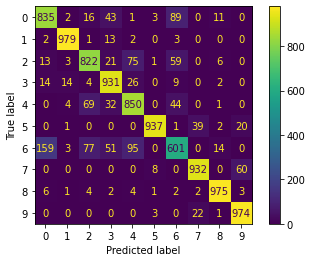

In [18]:
y_test = []
y_predict = []

model.eval()
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    y_test.append(labels)
            
    test = Variable(images.view(b_size, 1, 28, 28))
            
    outputs = model(test)
            
    predictions = torch.max(outputs, 1)[1].to(device)
    y_predict.append(predictions)
    
y_test    = torch.cat(y_test).cpu().numpy()
y_predict = torch.cat(y_predict).cpu().numpy()
ConfusionMatrixDisplay(confusion_matrix(y_test, y_predict)).plot()

Явно видно, что еще модель все еще путает футболко-подобную одежду, но тем не менее это значительно лучше простой по-пиксельной модели.